## Tarea Active Learning
### Autores:
María Bellver<br>
Alejandro Sanz<br>

### Objetivo

El principal objetivo de este trabajo es familiarizarse con el manejo de diferentes algoritmos de aprendizaje activo y diferentes criterios de diversidad, para el dataset de Semeion Handwritting Digit de la UCI.

### Algotimos de Active Learning

Los algoritmos de Active Learning son un caso especial de algoritmos de Machine Learning que permiten de forma interactiva consultar al usuario (o otra fuente de información), con el fin de obtener un nuevo conjunto de datos óptimo. Esto es particularmente útil cuando tenemos un conjunto de datos no etiquetados y se desea etiquetarlos, siendo el etiquetado manual demasiado costoso.

### Conjunto de datos

Este conjunto de datos contiene 1593 registros (filas) y 256 variables (columnas). Los registros son números manuscritos digitalizados tomados para 80 personas, estirados en cajas rectangulares de 16x16 y en escala de grises de 256 valores. Donde cada pixel se ha escalado a un booleano (0/1).

### Algotimos y divesidad

Para la realización de este trabajo vamos a hacer uso de algoritmos de aprendizaje reforzado, donde emplearemos como clasificador base un SVM para poder clasificar las muestras no etiquetadas de las que disponemos.<br>
Se hará uso de las diferentes estrategias de Active learning:


* Margin Sampling(MS)
* Multiclass level uncertaninty (MCLU)
- Significance space construction (SSC)
- Normalized entropy query-by-bagging (nEQB)

Con criterios de diversidad:

* Most Ambiguos and Orthogonal (MAO)
* Multiclass level uncertainty - angle-based diversity (MCLU-ABD/Lambda)
- Diversity by clustering (Clustering)

### Carga de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons as make_toy
# from sklearn.datasets import make_circles as make_toy
from sklearn.svm import SVC
from al_base import ao, show_results
# Import RBF kernel
from sklearn.metrics.pairwise import rbf_kernel
#import random as rd
from sklearn.cluster import KMeans
from sklearn.utils import resample
from scipy.spatial.distance import pdist
import sklearn

### Carga datos

In [2]:
data_et=pd.read_csv('semeion_labeled.csv',header=None)
data_noet=pd.read_csv('semeion_unlabeled.csv',header=None)
data_test=pd.read_csv('semeion_test.csv',header=None)

## Definiciones:

### Clase AO

Definimos una clase que empleremos para definir los conjuntos de  datos etiquetados, no etiquetados y de test. Así como para realizar copias de los datos originales ya que al implementar diferentes algoritmos y varias diversidades será necesario hacer uso de la copia, para el correcto funcionamiento.

In [3]:
class ao:
    """ AO (active object) class. """

    def __init__(self):
        self.colors = ['r', 'g', 'b', 'k', 'm']
        self.classifier = None
        self.xlab, self.ylab, self.xunlab, self.yunlab = None, None, None, None
        self.idx, self.acc = None, None
        self.gamma, self.C = 1.0, 100

    def setup(self,X_et,X_noet,test,labeled_size):
        """
        Setup test, labeled and unlabeled datasets.
        Returns the test dataset, for final validation.
        """

        # Define training data in labeled/unlabeled and test data
        self.xunlab, self.xlab, self.yunlab, self.ylab , xtest, ytest= \
            (np.array(X_noet.iloc[:,1:257]), np.array(X_et.iloc[:,1:257]),np.array(X_noet[[0]]), 
             np.array(X_et[[0]]),np.array(test.iloc[:,1:257]),np.array(test[[0]]))
        
        # Classifier: SVM
        sigma = np.mean(pdist(self.xlab))
        self.gamma = 1 / (2 * sigma * sigma)
        self.classifier = SVC(C=self.C, gamma=self.gamma, decision_function_shape='ovr')
        self.idx = []
        self.acc = []
        
        return xtest, ytest


    def copy(self):
        """
        Create a copy of itself by creating a new ao object and copying contents.
        """
        copy = ao()
        copy.xlab = self.xlab.copy()
        copy.xunlab = self.xunlab.copy()
        copy.ylab = self.ylab.copy()
        copy.yunlab = self.yunlab.copy()
        copy.gamma = self.gamma
        copy.C = self.C
        copy.classifier = SVC(C=self.C, gamma=self.gamma, decision_function_shape='ovr')
        copy.idx = self.idx.copy()
        copy.acc = self.idx.copy()
        return copy

    def updateLabels(self, idx):
        """
        Move selected samples from unlabeled to labeled set.
        """
        self.xlab = np.concatenate((self.xlab, self.xunlab[idx, :]), axis=0)
        self.ylab = np.concatenate((self.ylab, self.yunlab[idx]), axis=0)
        self.xunlab = np.delete(self.xunlab, idx, axis=0)
        self.yunlab = np.delete(self.yunlab, idx, axis=0)
        # Save them
        self.idx.append(idx)

    def score(self, xtest, ytest):
        """ Compute score on xtest/ytest, appends to self.acc and returns estimated value. """
        acc = self.classifier.score(xtest, ytest)
        self.acc.append(acc)
        return acc

    # Here are convenient functions to show results graphically



### Diversidad

In [1]:
def mao(idx,query_points,active):
            
            #==========================================================================
            # Apply diversity criterium
            # MAO: most ambigous and orthogonal
            #==========================================================================

            # We cannot limit the number of points in idx to query_points, but
            # we cannot use all points either, otherwise appart from the first point,
            # the rest will be selected using only the diverse criterion, and not the
            # uncertainty criterion

            # Lets limit the pool of possible samples as:
                idx = idx[0:query_points * 10]
                

            # Measure distances using the kernel function
                K = rbf_kernel(active.xunlab, gamma=active.gamma)

                Sidx = np.zeros(query_points, dtype=type(idx[0]))
                for j in np.arange(query_points):
                    # Add the first point (and remove it from pool)
                    
                    Sidx[j] = idx[0]
                    
                    idx = idx[1:]
                    # print(Sidx, idx.shape)

                    # Compute distances (kernel matrix)
                    # Distances between selected samples (Sidx) and the rest (idx)
                    Kdist = K[Sidx[0:j+1],:][:,idx]
                    # Obtain the minimum distance for each column
                    Kdist = Kdist.min(axis=0)

                    # Re-order by distance
                    idx = idx[Kdist.argsort(axis=0)]
                    

                return Sidx


def lambda_div(idx,query_points,active,yp,al):

            #==========================================================================
            # MAO with lambda
            #==========================================================================
            K = rbf_kernel(active.xunlab, gamma = active.gamma)
            lam = 0.6
            Sidx = np.zeros(query_points, dtype=type(idx[0]))
            for j in np.arange(query_points):
                # Add the first point, and remove it from pool
                Sidx[j] = idx[0]
                idx = idx[1:]
                # print(Sidx, idx.shape)

                # Compute distances (kernel matrix)
                # Distances between selected samples (Sidx) and the rest (idx)
                Kdist = np.abs(K[Sidx[0:j+1],:][:,idx])
                # Obtain the minimum distance for each column
                Kdist = Kdist.min(axis=0)

                # Trade-off between MS and Diversity
                if al == "ssc":
                    heuristic = yp[idx, -1] * lam + Kdist * (1 - lam)
                else:
                    heuristic = yp[idx] * lam + Kdist * (1 - lam)
                idx = idx[heuristic.argsort()]  # axis=0
                

            return Sidx


def clustering(idx,query_points,active):

            #==========================================================================
            # Cluster-based diversity
            #==========================================================================
            kmeans = KMeans(n_clusters=min(query_points,len(active.xunlab[idx])),random_state = SEED)
            # We can limit the pool of candidates when clustering to relax the
            # computational burden, but in principle using all unlabeled samples should
            # obtain a better partition
            # idx = idx[0:3*queried_points]
            
            # 1. Cluster the unlabeled set
            clusterIDs = kmeans.fit_predict(active.xunlab[idx])
            
            # 2. Select one sample per cluster. More specifically, select the first
            #    point in idx, already sorted according the MS uncertainty criterion
            Sidx = np.zeros((query_points,), dtype=int)
        
            for j in np.arange(query_points):
                Sidx[j] = idx[clusterIDs == j][0]
            
            
            
            return Sidx



### Algotimos de Aprendizaje activo

In [ ]:
def ms(div,num_queries,query_points, active,random,xtest, ytest):
    
            
            active_copy= active.copy()
            for i in np.arange(num_queries):

                #==========================================================================
                # Now on active learning
                #==========================================================================
                active_copy.classifier.fit(active_copy.xlab, active_copy.ylab.ravel())
                acca = active_copy.score(xtest, ytest)
                # Predict on unlabeled data
                dist = np.abs(active_copy.classifier.decision_function(active_copy.xunlab))
                dist = np.sort(dist, axis = 1)
                dist = dist[:, 0] #why
                
                # Sort by minimum distance
                idx = np.argsort(dist)  # [0:query_points] # < NO, points are selected using the div. crit.
                
                
     
                if (div == 'mao'):

                    Sidx= mao(idx,query_points,active)

                elif (div == 'lambda_div'):

                    Sidx= lambda_div(idx,query_points,active,dist,'ms')

                elif (div == 'clustering'):

                    Sidx= clustering(idx,query_points,active)


                # Move selected samples from unlabeled set to labeled set
                active_copy.updateLabels(Sidx)
        

            return(active_copy.acc)

def mclu(div,num_queries,query_points, active,random,xtest, ytest):
            
            
            active_copy= active.copy()
    
            for i in np.arange(0, num_queries):
        
                # Same for active model, but
                active_copy.classifier.fit(active_copy.xlab, active_copy.ylab.ravel())
                acca = active_copy.score(xtest, ytest)
                
                # 3. Use heuristic to choose samples from pool
                dist = np.abs(active_copy.classifier.decision_function(active_copy.xunlab))
                
                dist = np.sort(dist, axis=1)
                
                idx = np.argsort(dist[:,-1] - dist[:,-2])
                dist=dist[:,0]
                
                if (div == 'mao'):

                    Sidx= mao(idx,query_points,active)

                elif (div == 'lambda_div'):

                    Sidx= lambda_div(idx,query_points,active_copy,dist,'mclu')

                elif (div == 'clustering'):

                    Sidx= clustering(idx,query_points,active_copy)
                
                
                # Move selected samples from unlabeled set to labeled set
                active_copy.updateLabels(Sidx)
                
            return(active_copy.acc)
        
def ssc(div,num_queries,query_points, active,random, xtest, ytest):
    
        
        active_copy= active.copy()
        #random_copy= active.copy()
        model = SVC(C=random.C, gamma=random.gamma)

        for i in np.arange(0, num_queries):
            
            # Same for active model, but
            active_copy.classifier.fit(active_copy.xlab, active_copy.ylab.ravel())
            acca = active_copy.score(xtest, ytest)

            # 3. Use heuristic to choose samples from pool
            xtr = active_copy.xlab
            ytr = active_copy.ylab
            ytr = np.zeros(ytr.shape)
            ytr[active_copy.classifier.support_] = 1
           
            if len(np.unique(ytr)) == 1:
                idx = np.random.permutation(active_copy.xunlab.shape[0])
            else:
                model.fit(xtr, ytr.ravel())
                possible_SVs = model.predict(active_copy.xunlab)
                idx = np.arange(active_copy.xunlab.shape[0])[possible_SVs == 1]
                
                idx = np.random.permutation(idx)
              
            
            dist = np.abs(active_copy.classifier.decision_function(active_copy.xunlab))
        
            if (div == 'mao'):
                    
                Sidx= mao(idx,query_points,active_copy)

            elif (div == 'lambda_div'):

                Sidx= lambda_div(idx,query_points,active_copy,dist,'ssc')

            elif (div == 'clustering'):

                Sidx= clustering(idx,query_points,active_copy)
                
                
            active_copy.updateLabels(Sidx)

        return(active_copy.acc)
            
def nEBQ(div,num_queries,query_points, active,random, xtest, ytest):
        
        
        classes = np.unique(np.arange(10))
        n_classes = len(classes)
        labeled_size = n_classes
       
        active_copy= active.copy()
        
        model = SVC(C=random.C, gamma=random.gamma)
        n_models = 2
        for i in np.arange(num_queries):
           
            # Same for active model, but
            active_copy.classifier.fit(active_copy.xlab, active_copy.ylab.ravel())
            acca = active_copy.score(xtest, ytest)

            # 3. Use heuristic to choose samples from pool
            n_unlab = active_copy.xunlab.shape[0]
            predMatrix = np.zeros((n_unlab, n_models))
            for k in range(n_models):
                # Replica bootstrap
                while True:
                    xbag, ybag = resample(active_copy.xlab, active_copy.ylab, replace=True)
                    # Ensure that we have all classes in the bootstrap replica
                    if len(np.unique(ybag)) >= n_classes:
                        break
                model.fit(xbag, ybag.ravel())
                predMatrix[:, k] = model.predict(active_copy.xunlab)

            # Count number of votes per class
            ct = np.zeros((active_copy.xunlab.shape[0], n_classes))
            for i, w in enumerate(classes):
                ct[:, i] = np.sum(predMatrix == w, axis=1)
            ct /= n_models

            Hbag = ct.copy()
            # Set to 1 where Hbag == 0 to avoid -Inf and NaNs (problem is that 0 * -Inf = NaN)
            Hbag[Hbag == 0] = 1
            Hbag = -np.sum(ct * np.log(Hbag), axis=1)
            
            
            

            logNi = np.log(np.sum(ct > 0, axis=1))
            # Avoid division by zero
            logNi[logNi == 0] = 1

            nEQB = Hbag / logNi

            # Select randomly one element among the ones with maximum entropy
           
            idx = np.where(nEQB == np.max(nEQB))[0]
            
            np.random.shuffle(idx)
            

            if (div == 'mao' or div == "lambda_div"):
                    
                Sidx= lambda_div(idx,query_points,active_copy,Hbag,'nEBQ')

            elif (div == 'clustering'):

                Sidx= clustering(idx,query_points,active_copy)
                
            active_copy.updateLabels(Sidx)

            
            
        return(active_copy.acc)


## Apartado 1:
    

Implementamos los algoritmos, de forma que realizaremos 30 queries y por cada query se seleccionarán 10 muestras que se clasificarán, es decir, se pasaran del conjunto de no etiquetadas al conjunto de etiquetadas. Tras esto, mostraremos de forma gráfica la comparación ante un método de muestreo aleatorio y el algorimo de aprendizaje activo empleado, con las diferentes diversidades.

In [4]:
def programita1(lab,nlab,test,al,div):
    # AL variables
    labeled_size = 10
    num_queries = 30
    query_points = 10
    random = ao()
    xtest, ytest = random.setup(lab,nlab,test, labeled_size=labeled_size)
    active = random.copy()
    
    for i in np.arange(0, num_queries):
                # 1. Fit random model
                random.classifier.fit(random.xlab, random.ylab.ravel())
                # 2. Obtain score on xtest, ytest
                accr = random.score(xtest, ytest)
                # 3. Choose some random samples from xunlab, yunlab
                idx = np.random.permutation(random.xunlab.shape[0])
                # 4. Call updateLabels to move them from pool to train
                random.updateLabels(idx[0:query_points])
                
    acr=random.acc
                
    aca= al(div,num_queries,query_points, active,random,xtest, ytest)
    
    
   
    #Compare accuracies
    plt.figsize=(10, 5)
    ejex = np.arange(0, 30)
    plt.plot(ejex, np.array(acr), label='random')
    plt.plot(ejex, aca, label='active')
    plt.suptitle("Acuracy Score: Random Metode vs " + al.__name__,fontsize=15)
    plt.title("Div:" + div, fontsize=13)
    plt.legend()  # ['Random', 'Active'])
    plt.grid()
    plt.show()
        
   
    return(acr, np.array(aca))

    

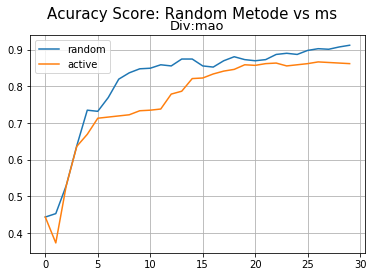

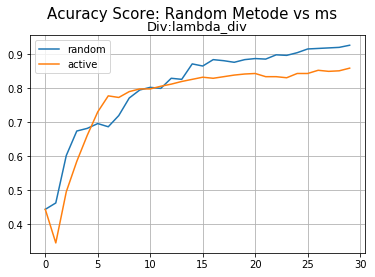

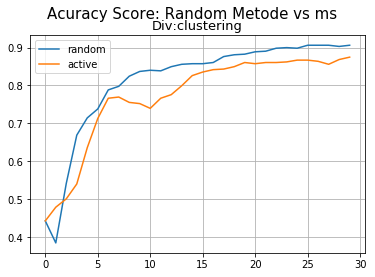

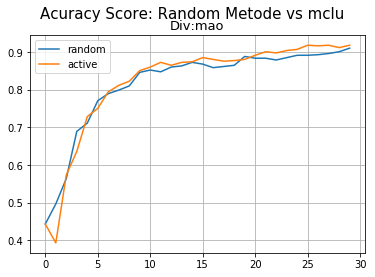

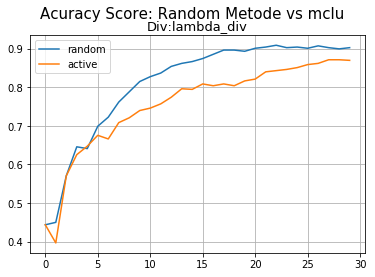

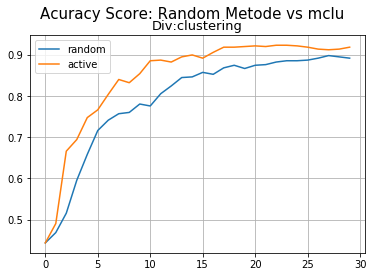

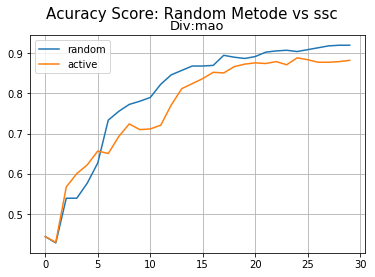

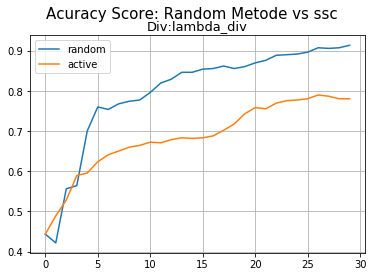

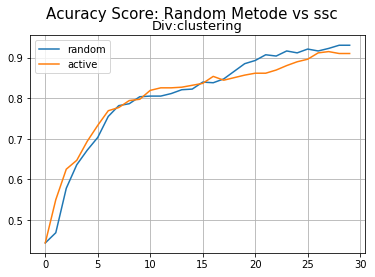

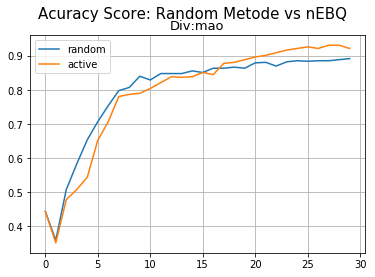

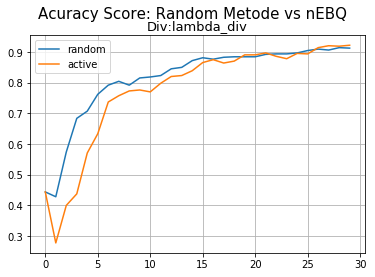

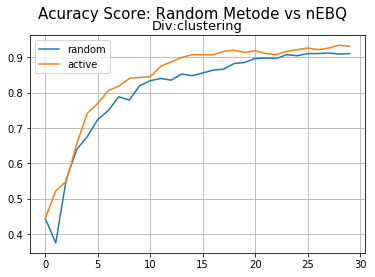

In [5]:
al=[ms,mclu, ssc,nEBQ]
div=['mao','lambda_div','clustering']
algo=['ms','mclu', 'ssc','nEBQ']
#rd.seed(47)
k=0
for i in al:
    for j in div:
        acr,aca=programita1(data_et,data_noet,data_test,i,j)
    k+=1    

### Resultados obtenidos

* MS:<br>
Con el algoritmo MS y las 3 diversidades empleadas no se observa una mejora del acierto de la clasificación sobre el muestreo aleatorio. Cabe destacar que en poco más de 10 queries los tres métodos superan el 0.8 de acuracy.
* MCLU:<br>
Con el algoritmo MCLU, la diversidad que arroja mejores aciertos en la clasificación es la diversidad de clustering, llegando a ser bastante mejor que para el muestreo aleatorio desde las primeras queries. Para las otras 2 diversidades, mientras que para diversidad mao no se aprecia gran diferencia con el random, obteniendo un acuracy de 0.8 en poco más de 5 queries, para la diversidad lambda el muestreo aleatorio es superior a partir de las 5 queries.
* SSC:<br>
Con el algoritmo SSC el mejor acierto de clasificación se obtiene para la diversidad clustering pero no llega a superar un acuracy de 0.9 hasta pasadas las 25 queries y tampoco se aprecia diferencia respecto al muestreo aleatorio. Para los otros 2 criterios de diversidad empleados, los resultados obtenidos son peores que para el muestreo aleatorio.
* nEQB:<br>
Finalmente con el algoritmo nEQB, pese a que el acuracy a partir de 10 queries ronda el 0.8 en los tres métodos de diversidad, se obtiene un mejor resultado para la diversidad clustering ya que desde el comienzo supera al muestreo aleatorio.

 Se puede concluir que los algoritmos MCLU y nEQB con diversidad clustering son los que han obtenido un mejor funcionamiento, ya que a partir de 5 queries rondan un 0.8 de acuracy y con 10 queries el 0.9 superando los el muestreo aleatorio.

## Apartado 2:

En este apartado vamos a realizar de nuevo lo mismo que en el apartado anterior, no obstante se  repetirá el experimento un total de 50 veces y obtendremos la media y la desviación típica del acuracy en cada query de éstos. Tras esto realizaremos las gráficas para todos los algoritmos y métodos de diversidad empleados comparando las medias obtenidas, incluyendo un sombreado de 2 veces la desviación típica, frente al muestreo aleatorio. Con el fin de comprobar si el hecho de repetir los experimentos nos permite obtener unos aciertos en las clasificaciones mejores que las obtenidas en el apartado anterior.

In [7]:
def programita2(lab,nlab,test,al,div):
    # AL variables
    labeled_size = 10
    num_queries = 30
    query_points = 10
    random = ao()
    xtest, ytest = random.setup(lab,nlab,test, labeled_size=labeled_size)
    active = random.copy()
    
    acr=[]
    aca=[]          
    ex_act=[]
    media=[]
    desv=[]
    ac=[]
    
    for i in np.arange(0, num_queries):
                # 1. Fit random model
                random.classifier.fit(random.xlab, random.ylab.ravel())
                # 2. Obtain score on xtest, ytest
                accr = random.score(xtest, ytest)
                # 3. Choose some random samples from xunlab, yunlab
                idx = np.random.permutation(random.xunlab.shape[0])
                # 4. Call updateLabels to move them from pool to train
                random.updateLabels(idx[0:query_points])
    acr=random.acc
    
    for k in np.arange(50):
            
        aca= al(div,num_queries,query_points, active, random, xtest, ytest)
        ex_act.append(aca)
        
    
        
    for l in np.arange(30):
            for n in np.arange(50):
                    ac.append(ex_act[n][l])
                    
            media.append(np.mean(ac))
            desv.append(np.std(ac))
            ac=[]
            
    #Compare accuracies
    plt.figure()
    ejex = np.arange(0, 30)
    plt.plot(ejex, np.array(acr), label='random')
    plt.plot(ejex, np.array(media), label='active')
    plt.fill_between(ejex, np.array(media)+2*np.array(desv), np.array(media)+(-2*np.array(desv)),facecolor="orange", alpha=0.2)  
    plt.legend()  # ['Random', 'Active'])
    plt.suptitle("Acuracy Score: Random Metode vs " + al.__name__,fontsize=15)
    plt.title("Div:" + div, fontsize=13)
    plt.grid()
    plt.show()
    
   
    return(acr, media)

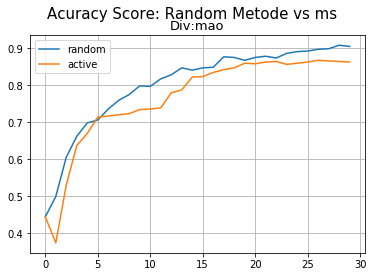

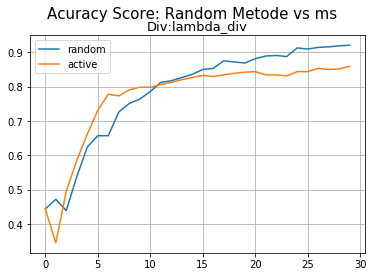

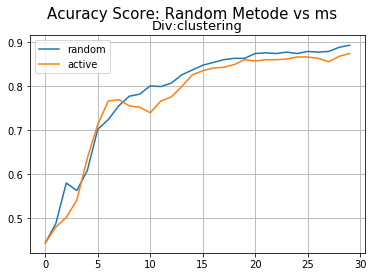

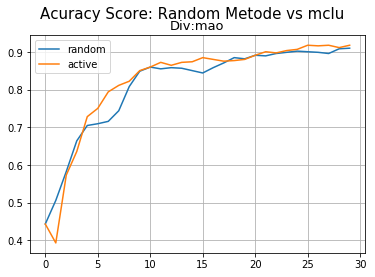

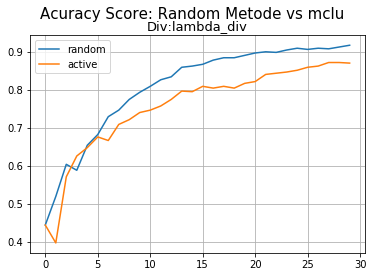

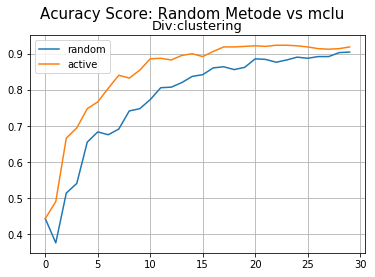

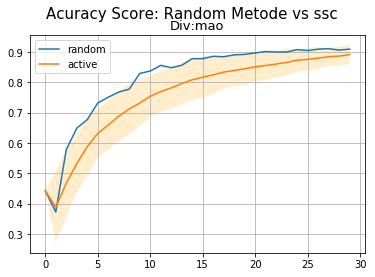

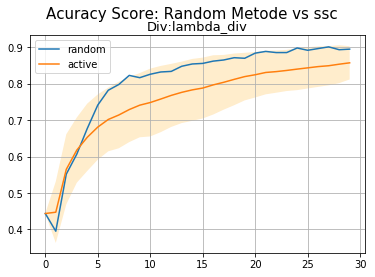

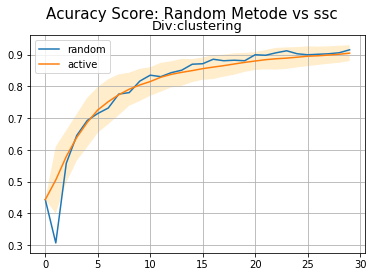

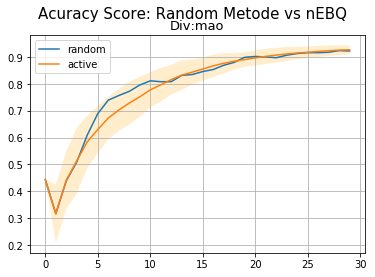

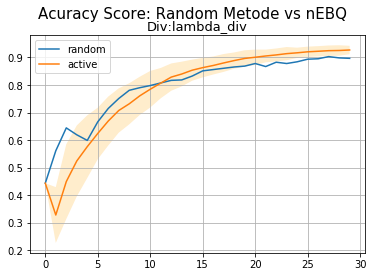

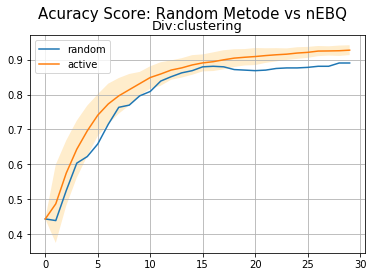

In [8]:
al=[ms,mclu, ssc,nEBQ]
div=['mao','lambda_div','clustering']
algo=['ms','mclu', 'ssc','nEBQ']
#rd.seed(47)

for i in al:
    for j in div:
        acr,media_ac=programita2(data_et,data_noet,data_test,i,j)
    

### Resultados obtenidos

* MS:<br>
Con el algoritmo MS y las 3 diversidades empleadas no se observa una mejora del acierto de la clasificación sobre el muestreo aleatorio, considerando que se ha  repetido del experimento 50 veces. Así mismo, no se obseva el sombreado de 2 veces la desviación típica debido a que el algoritmo obtiene los mismos valores para los aciertos de clasificación en todos los casos, lo que explica que no mejore los resultados frente a lo obtenido en el apartado anterior.
* MCLU:<br>
Con el algormitmo MCLU también obtenemos los mismos resultados que en el apartado 1 ya que, como pasaba con el algoritmo MS, para cada uno de los 50 experimentos se ha obtenido el mismo acierto. Este hecho se ve reflejado en la desviación típica, la cual se observa rápidamente que es nula con la falta de sombreado.
* SSC:<br>
Con el algoritmo SSC, en todos los casos para las diversidades empleadas, la media de los aciertos de clasificación no funciona mejor que el muestreo aleatorio, no obstante destaca la diversidad clustering que obtiene 0.8 de acuracy antes de las 10 queries.
* nEQB:<br>
Finalmente con el algoritmo nEQB, se obtiene un mejor rendimiento para todos los casos, destacando la diversidad clustering ya que supera un 0.9 de acuracy a partir de las 15 queries y obtiene mejores resultados que el muestreo aleatorio desde el principio. 

Por lo tanto, como en el apartado anterior, los mejores resultados se obtienen con los algoritmos MCLU y nEQB utilizando diversidad clustering.